# 3. ImageClassificationPipeline与机器视觉分类任务

## 3.1. Trandformers中分类任务实现框架

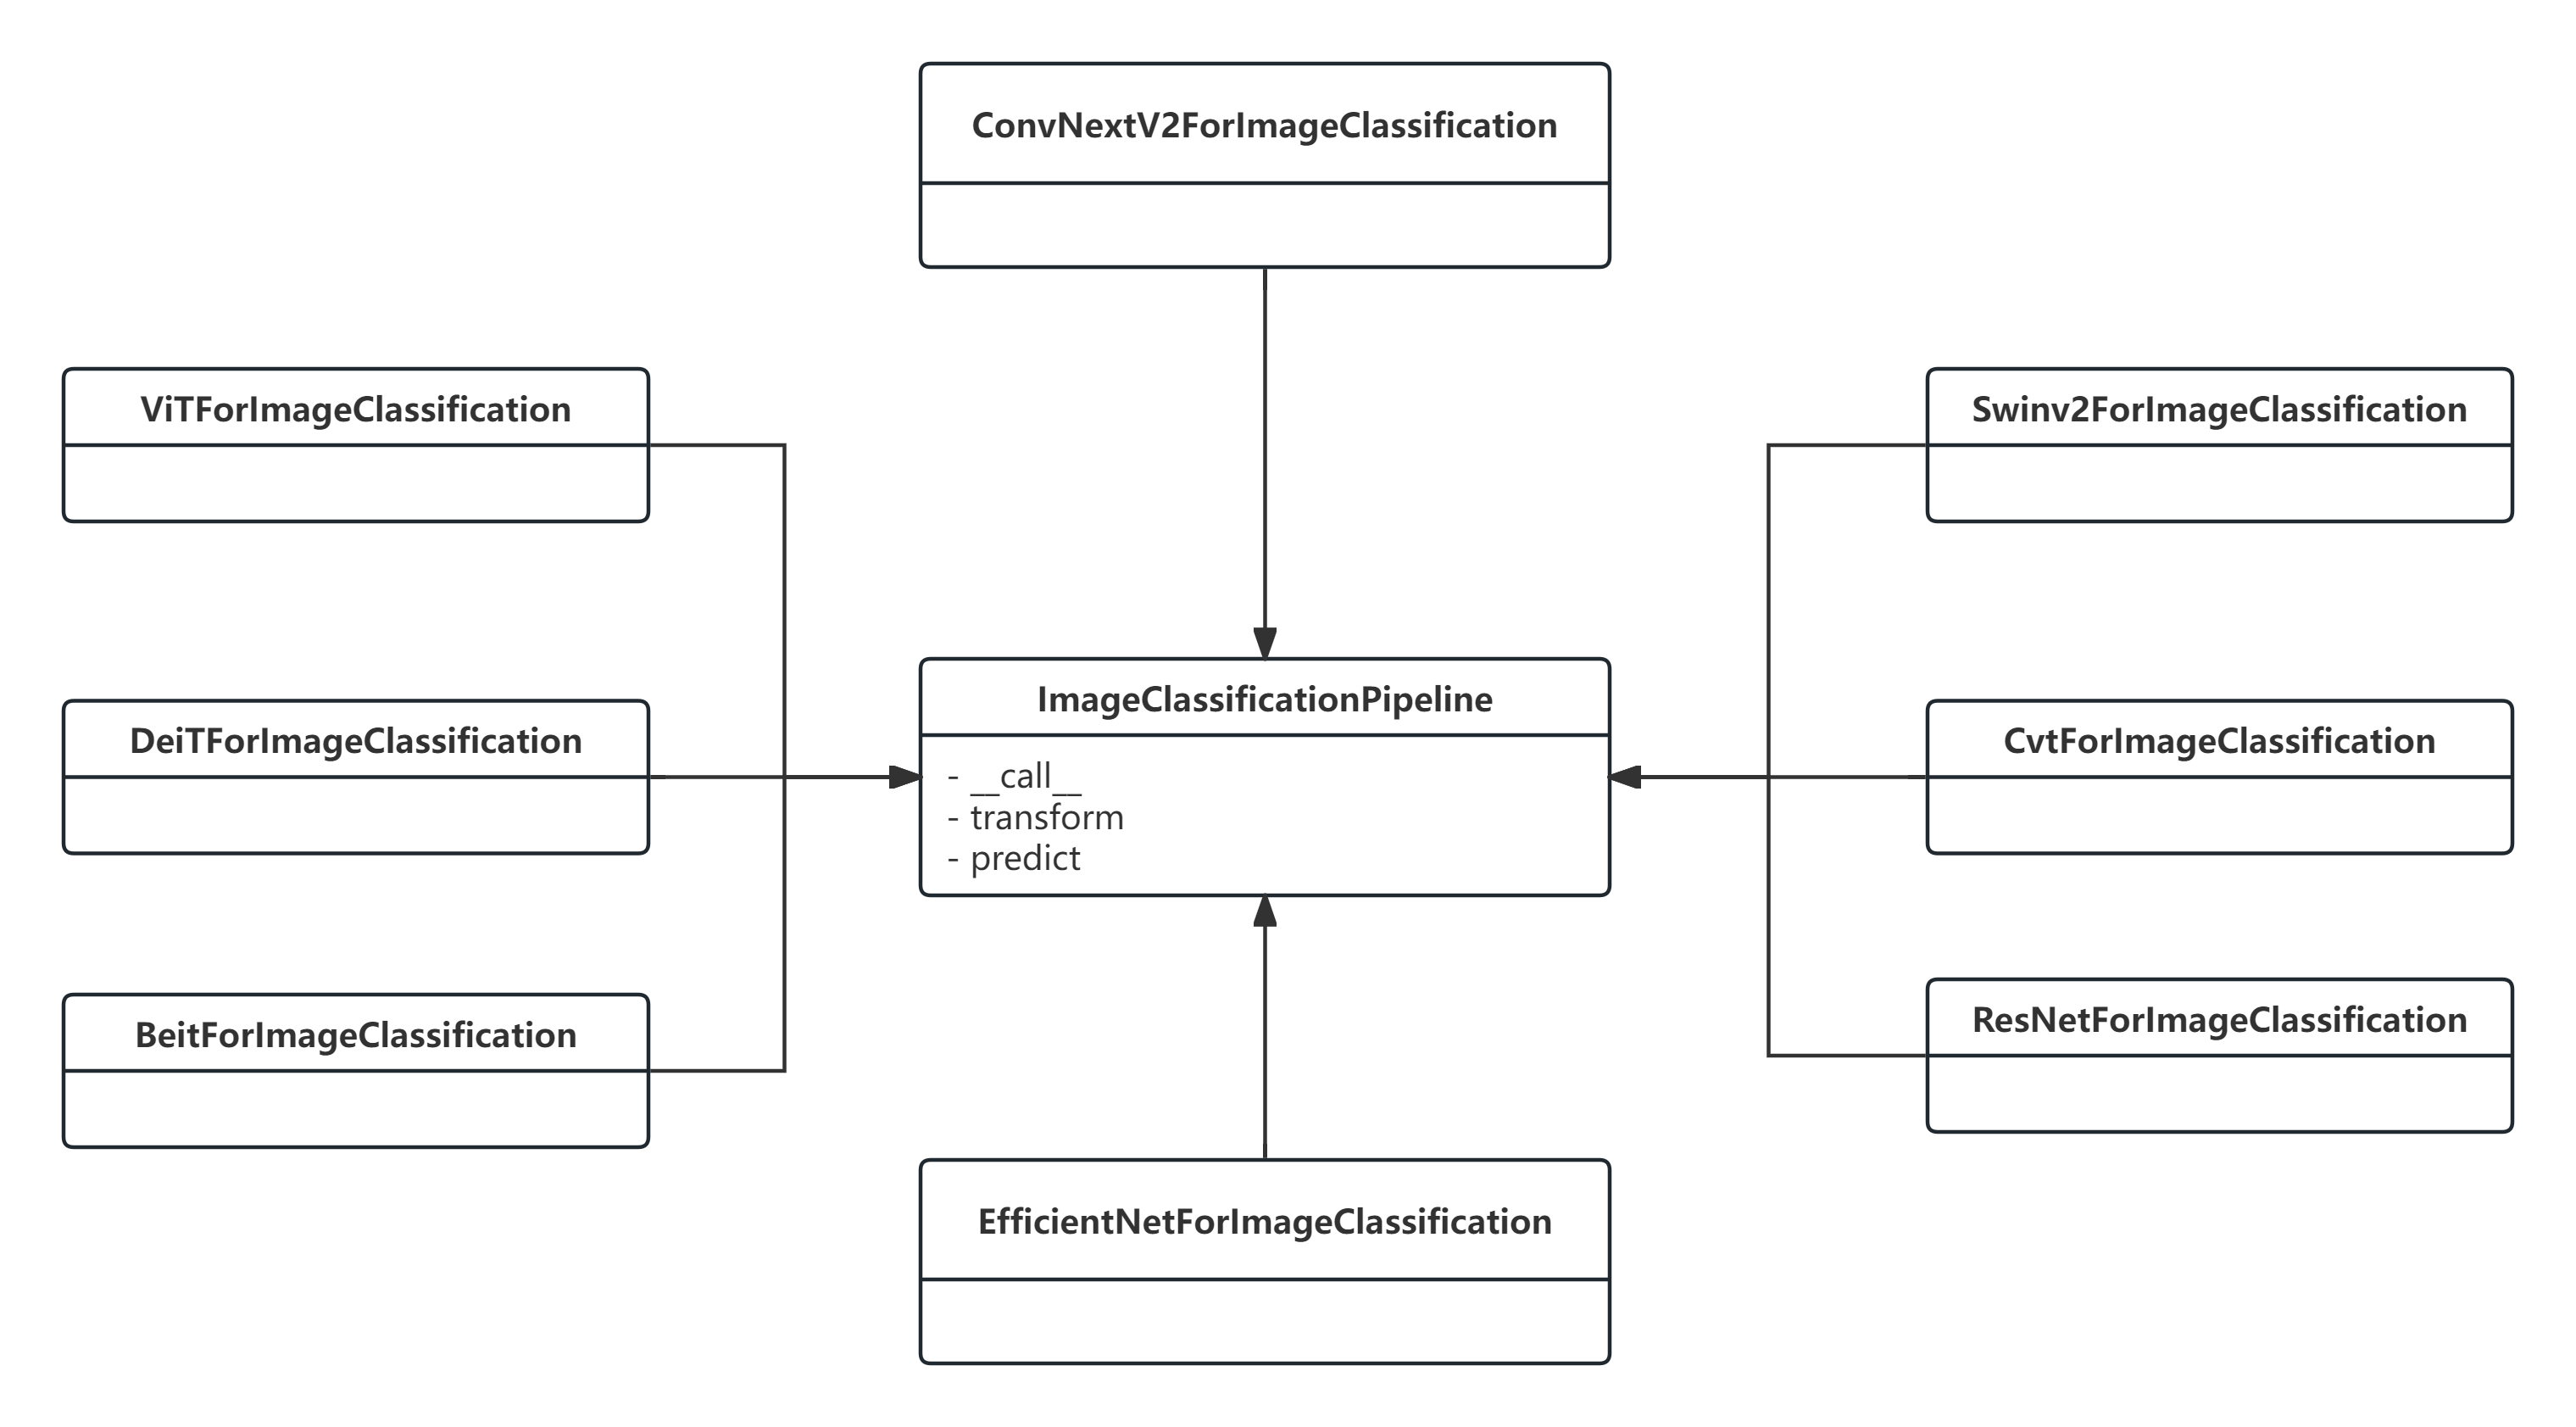

- 上图我们仅仅是列出部分分类模型实现，下面是更多的列表：
    - BEiT
    - BiT (Big Transfer)
    - ConvNeXT与ConvNeXt V2
    - CvT (Convolutional Vision Transformer)
    - DeiT
    - DiNAT (Dilated Neighborhood Attention Transformer)
    - DINOv2与DINOv2 with Registers
    - EfficientFormer
    - EfficientNet
    - FocalNet
    - Hiera
    - I-JEPA
    - ImageGPT
    - LeViT
    - MobileNet V1与MobileNet V2
    - MobileViT与MobileViTV2
    - NAT (Neighborhood Attention Transformer)
    - PoolFormer
    - PVT (Pyramid Vision Transformer)与PVTv2
    - RegNet
    - ResNet
    - SegFormer
    - SwiftFormer
    - Swin Transformer与Swin Transformer V2
    - TextNet
    - TimmWrapper
    - VAN
    - ViT (Vision Transformer)
    - ViT Hybrid (Hybrid Vision Transformer)
    - ViTMSN
    - 注意：有的算法不仅仅只执行一个任务。比如分类与目标侦测很多时候能实现。

- 在Transformers框架中，每个算法的实现结构如下：（以ViT算法为例）
    - pipeline封装函数
        - ImageClassificationPipeline算法的管道类封装：
            - ViTForImageClassification分类算法实现
                - ViTModel推理模型
                    - ViTConfig模型配置
                - ViTImageProcessor图像处理器（预处理与后后处理）
                    - ViTFeatureExtractor（在Transformers以后会取消，不建议推荐）
                    - ViTImageProcessorFast（快捷实现）

- 我们选择如下几个算法来说明机器视觉的分类任务:
    - ViT
    - DeiT
    - BEiT
    - Swin Transformer
    - ConvNeXt
    - BEiT
    - CvT (Convolutions to Vision Transformers)
    - EfficientNet
    - 注意：分类任务还与训练的图像数据集有关。

## 3.2. ViT模型的使用

### (1) 模型介绍

- Vision Transformer(ViT)模型在ImageNet-21k（1400 万张图片，21,843 个类别）上以 224x224 的分辨率预训练，并在 ImageNet 2012（100 万张图片，1,000 个类别）上以 224x224 的分辨率进行微调。
    - 该模型由Dosovitskiy等人在论文`An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`中提出。

### (2) 模型下载 

- `git clone https://www.modelscope.cn/google/vit-base-patch16-224.git`

### (3) pipeline使用方式

In [9]:
import torch
from transformers import pipeline, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("F:/03Models/vit-base-patch16-224", use_fast=True)
pipe = pipeline(
    task="image-classification",
    model="F:/03Models/vit-base-patch16-224",
    image_processor=image_processor,
    torch_dtype=torch.float16,
    device="cuda",
    use_fast=True  # 该参数只有支持ViTImageProcessorFast的时候，用来传递给加载函数的。
)
print(type(pipe))
print(type(pipe.image_processor))
print(type(pipe.model))
print(type(pipe.model.config))
# COCO数据集中选择的图像
outputs = pipe(inputs="./imgs/000000039769.jpg", top_k=2)
print(outputs)

Device set to use cuda


<class 'transformers.pipelines.image_classification.ImageClassificationPipeline'>
<class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'>
<class 'transformers.models.vit.modeling_vit.ViTForImageClassification'>
<class 'transformers.models.vit.configuration_vit.ViTConfig'>
[{'label': 'Egyptian cat', 'score': 0.9372360706329346}, {'label': 'tabby, tabby cat', 'score': 0.038684356957674026}]


- 代码说明：
    - 输出结果根据top_k参数而定。按照概率大小，返回top_k指定的候选分类结果。
    - 返回的是字典列表，字典的字段包含两个：
        - label：分类标签。
        - score：分类概率。

### (4) ViTForImageClassification使用方式

- ViTForImageClassification对象的构造使用构造器。其构造器原型定义与参数说明如下：
    - `def __init__(self, config: ViTConfig)`
        - config参数：模型配置对象。
    - ViTForImageClassification是图像分类器，其本质是：ViTModel（模型特征） + 分类器（线性分类器：全连接网络）

In [20]:
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessorFast
import torch
from PIL import Image

# 模型配置
config = ViTConfig.from_pretrained("F:/03Models/vit-base-patch16-224")

# 通过配置加载模型，也可以直接加载模型
# classfication = ViTForImageClassification(config)
classfication = ViTForImageClassification.from_pretrained("F:/03Models/vit-base-patch16-224")
# 图像处理器（预处理与后处理）
image_processor = ViTImageProcessorFast.from_pretrained("F:/03Models/vit-base-patch16-224")

# 使用GPU
classfication = classfication.to("cuda")

# 处理流程  - 预处理
img_file = "./imgs/000000039769.jpg"
# image = Image.open(img_file)
inputs = image_processor(images=img_file, return_tensors="pt").to("cuda")   # 把模型输入也移动到GPU
pixel_values = inputs.pixel_values

# 处理流程  - 推理
with torch.no_grad():
    # outputs = classfication(pixel_values)
    outputs = classfication(**inputs)
logits = outputs.logits
logits.shape   # 1000个类别

# 处理流程  - 后处理
prediction = logits.argmax(-1)
print(prediction)  # 预测结果

# 转换为可读标签
label = config.id2label[prediction.item()]
print("分类结果：", label)

tensor([285], device='cuda:0')
分类结果： Egyptian cat


- 代码说明：
    - 代码中我们采用了两种方式加载模型，第一种方式会导致模型权重参数加载不完全，推理结果明显不佳。
        - 第一种方式：`classfication = ViTForImageClassification(config)`
        - 第二种方式：`classfication = ViTForImageClassification.from_pretrained("F:/03Models/vit-base-patch16-224")`
    - - 后处理方式过程比较简单，但是比较专业（典型的分类器的处理方式）。
      - 预处理方式我们没有详细讲解，也是比较专业的调用：读取，缩放，转张量，标准化。

- 说明：
    - 可以直接通过Pipeline的封装来实现推理调用：
        - preprocess预处理
        - forward推理
        - postprocess后处理方式。

----

- 提示：
    - 还有更多模型，这里不重复介绍，使用方式都类似。